In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import torch
import copy
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim


In [2]:
## Dataset 1: Customer segmentation

##1. K Means clustering
##2. Expectation maximmization
##3. PCA
##4. ICA
##5. Randomized projections

In [3]:
# read data from csv
customer_segmentation=pd.read_csv("customer_segmentation.csv")
print(customer_segmentation.head()) #first 5 rows

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

In [4]:
customer_segmentation.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [5]:
#replace null value with median for income column
customer_segmentation['Income'].fillna(customer_segmentation['Income'].median(), inplace = True)

In [6]:
# Replace categorical variables with numeric values
label_encoder = LabelEncoder()
customer_segmentation['Education'] = label_encoder.fit_transform(customer_segmentation['Education'])
customer_segmentation['Marital_Status'] = label_encoder.fit_transform(customer_segmentation['Marital_Status'])

In [7]:
customer_segmentation = customer_segmentation.drop(columns = ['Dt_Customer', 'ID'], axis = 1)

In [8]:
customer_segmentation.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1957,2,4,58138.0,0,0,58,635,88,546,...,7,0,0,0,0,0,0,3,11,1
1,1954,2,4,46344.0,1,1,38,11,1,6,...,5,0,0,0,0,0,0,3,11,0
2,1965,2,5,71613.0,0,0,26,426,49,127,...,4,0,0,0,0,0,0,3,11,0
3,1984,2,5,26646.0,1,0,26,11,4,20,...,6,0,0,0,0,0,0,3,11,0
4,1981,4,3,58293.0,1,0,94,173,43,118,...,5,0,0,0,0,0,0,3,11,0


In [9]:
# Selecting features for clustering
X = customer_segmentation

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

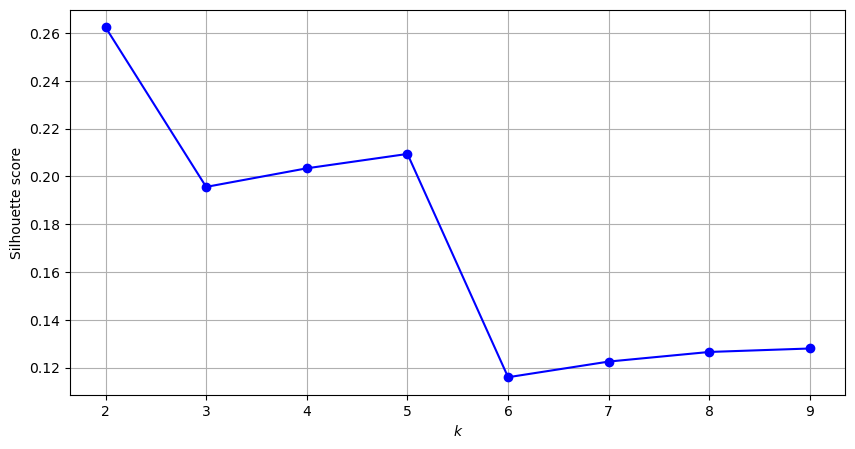

In [29]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(X_scaled, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

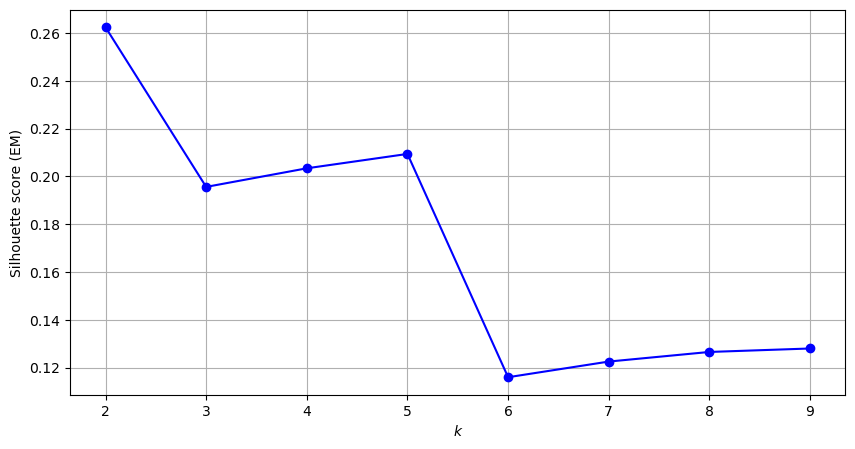

In [37]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(X_scaled)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(customer_segmentation, model.predict(X_scaled))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



In [21]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42, svd_solver = 'full')
pca.fit(X_scaled)
#cumulative sum
cumsum = np.cumsum(pca.explained_variance_ratio_)
dimention = np.argmax(cumsum >= 0.95) + 1

In [22]:
# minimum dimensions required to preserve 95% of the variance
dimention

21

In [23]:
cumsum

array([0.26071465, 0.34385853, 0.4204882 , 0.47854046, 0.52544146,
       0.56672981, 0.60686892, 0.64680104, 0.68463877, 0.71795056,
       0.74780201, 0.77555696, 0.80102294, 0.82540077, 0.84881847,
       0.87007074, 0.89075069, 0.90931015, 0.9265989 , 0.94289787,
       0.95796672, 0.97041374, 0.98254751, 0.99229998, 1.        ,
       1.        , 1.        ])

In [24]:
cumsum[21]

0.9704137389637469

In [25]:
cumsum[20]

0.9579667176437766

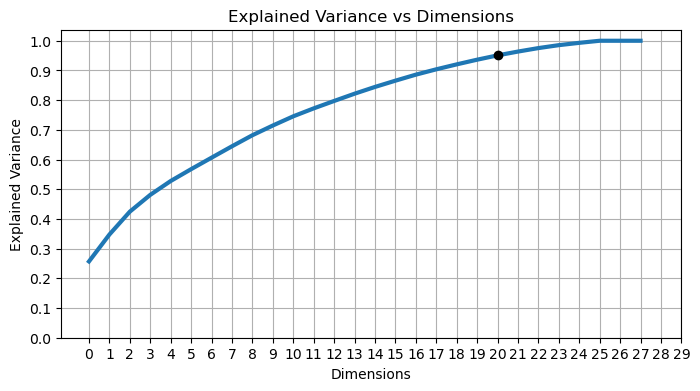

In [48]:
plt.figure(figsize = (8, 4))

plt.plot(cumsum, linewidth=3)

plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs Dimensions")
plt.plot(20, cumsum[20], "ko")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)

plt.show()

In [26]:
# Initiating PCA to reduce features to 20
pca = PCA(n_components = 20, random_state = 42, svd_solver = 'full')
pca.fit(X_scaled)
X_scaled_reduced = pd.DataFrame(pca.transform(X_scaled), columns = (['col1', 'col2', 'col3', 'col4',
                                                                  'col5', 'col6', 'col7', 'col8',
                                                                  'col9', 'col10', 'col11', 'col12',
                                                                  'col13', 'col14', 'col15', 'col16',
                                                                  'col17', 'col18', 'col19', 'col20']))

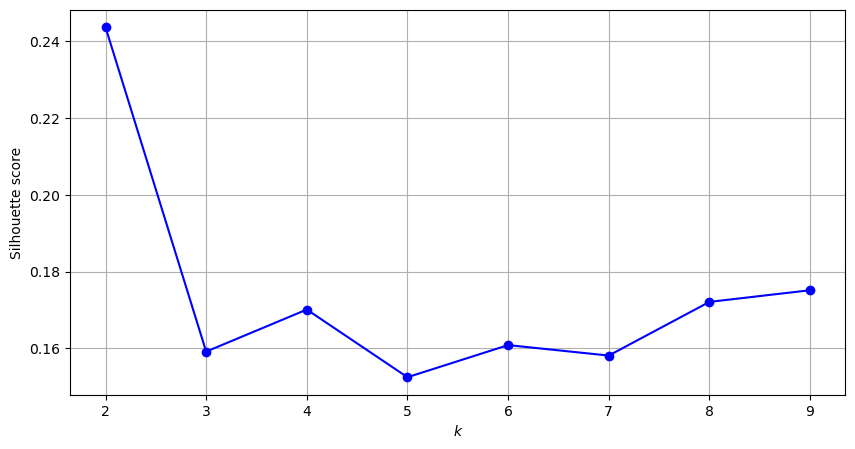

In [95]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled_reduced)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(X_scaled_reduced, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

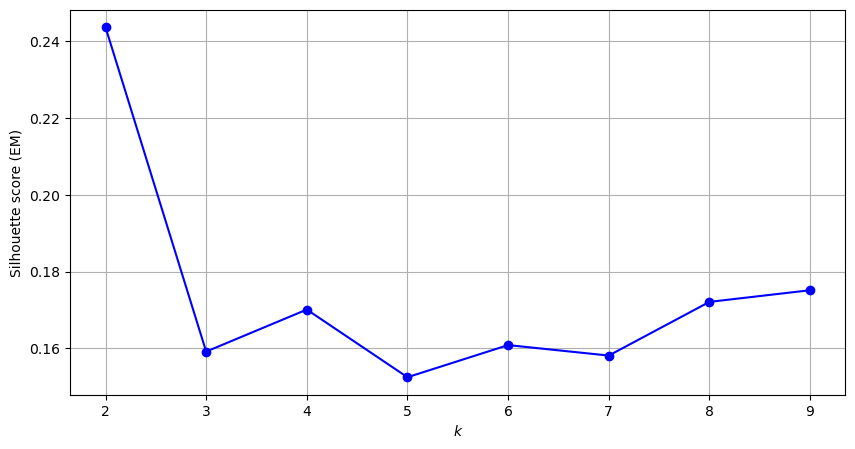

In [98]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(X_scaled_reduced)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(X_scaled_reduced, model.predict(X_scaled_reduced))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



C:\Users\Edward\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


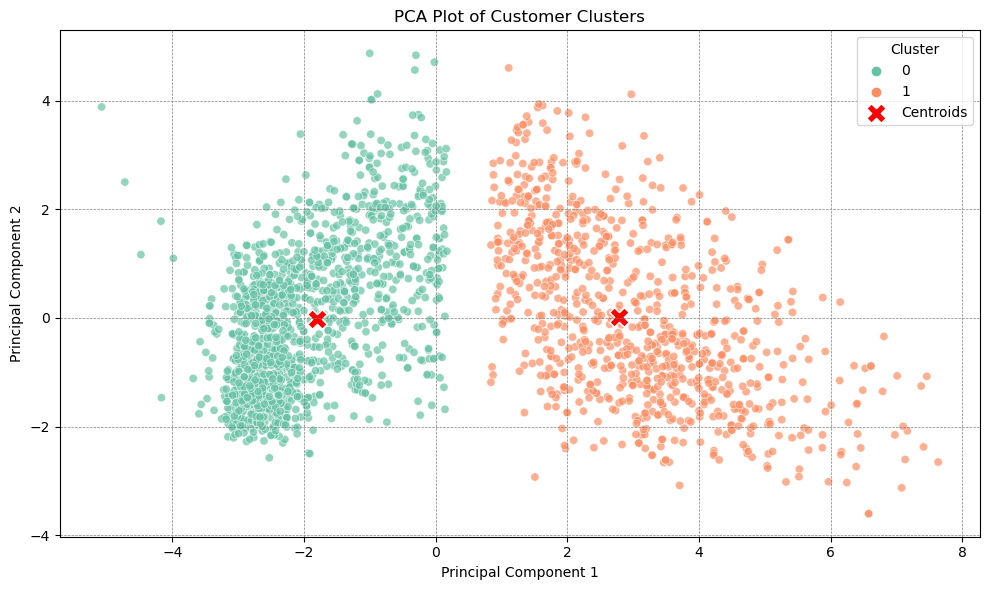

In [27]:
# Cluster Image

kmeans = KMeans(n_clusters= 2, random_state=42)  #change value of n_clusters
cluster_labels = kmeans.fit_predict(X_scaled_reduced)
customer_segmentation['Cluster'] = cluster_labels
customer_segmentation.to_excel('Clustered_data.xlsx', index = False)


df= pd.read_excel('Clustered_data.xlsx')

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

df['PC1'] = pca_data[:, 0]
df['PC2'] = pca_data[:, 1]


cluster_palette = sns.color_palette("Set2", n_colors = len(df['Cluster'].unique()))

plt.figure(figsize = (10, 6))

sns.scatterplot(df, x = 'PC1', y = 'PC2', hue = 'Cluster', palette = cluster_palette, alpha = 0.7)

plt.title("PCA Plot of Customer Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.grid(True)
plt.tight_layout()


plt.legend(title="Cluster", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], marker = 'X', s = 200, color = 'red', label = 'Centroids')
plt.legend(title = 'Cluster')


plt.show()

C:\Users\Edward\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


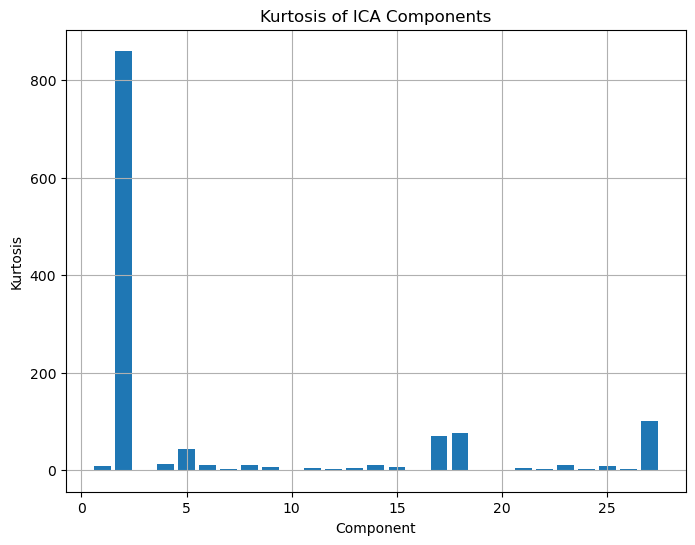

In [12]:
from sklearn.decomposition import FastICA
import scipy.stats as stats
from scipy.stats import kurtosis
# ICA
ica = FastICA(random_state=42)
reduced_data = ica.fit_transform(X_scaled)

# Calculate kurtosis for each component
component_kurtosis = kurtosis(reduced_data, axis=0)

# Plot the kurtosis values
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(component_kurtosis) + 1), component_kurtosis)
plt.xlabel('Component')
plt.ylabel('Kurtosis')
plt.title('Kurtosis of ICA Components')
plt.grid(True)
plt.show()

In [13]:
ica = FastICA(n_components=2, random_state=42)
reduced_data_ica = ica.fit_transform(X_scaled)

C:\Users\Edward\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


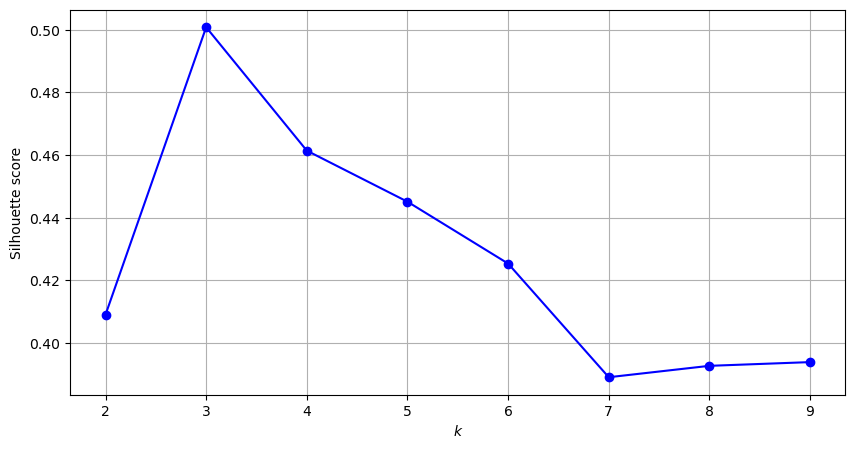

In [14]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(reduced_data_ica)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(reduced_data_ica, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

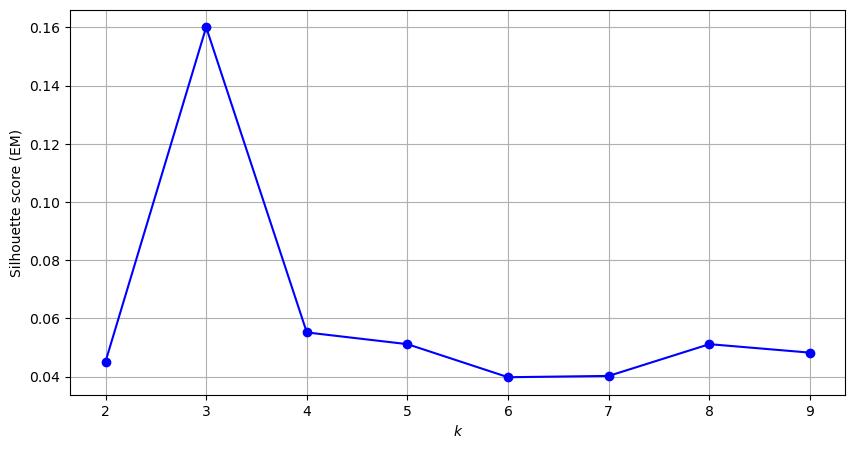

In [101]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(reduced_data_ica)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(reduced_data_ica, model.predict(reduced_data_ica))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



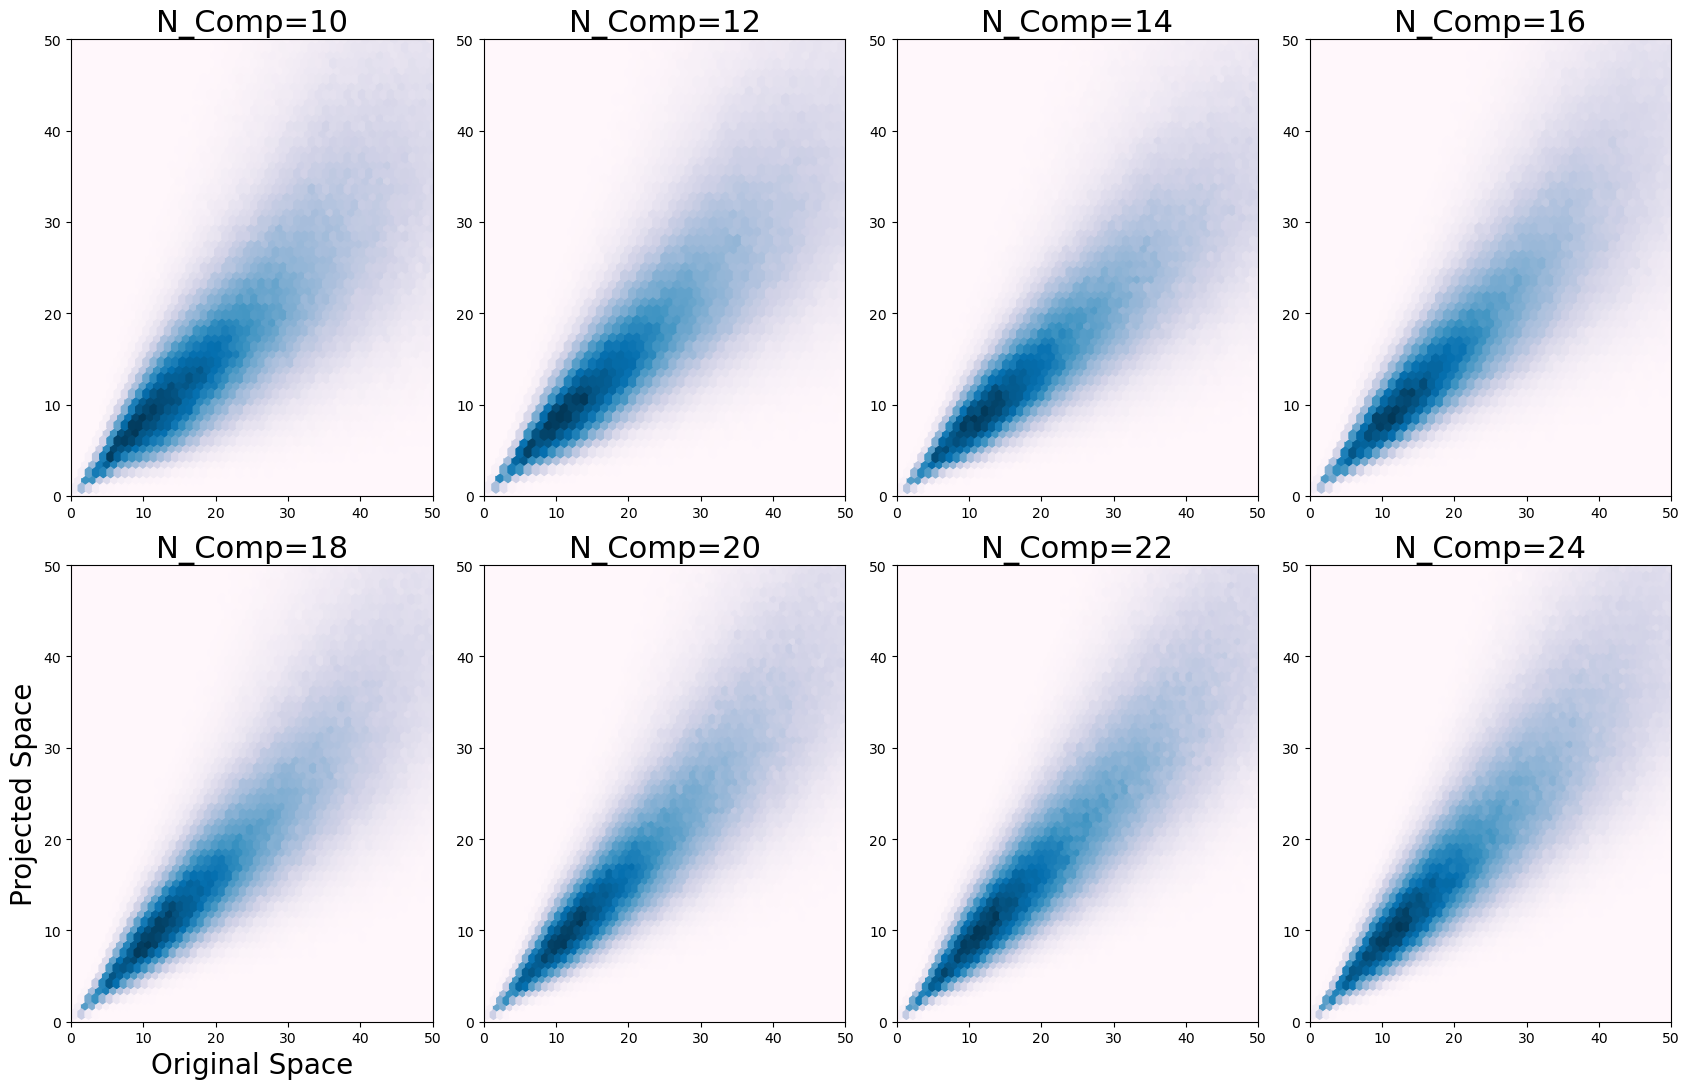

In [15]:

from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics.pairwise import euclidean_distances
# Define the range of dimensions to try
dimensions_range = range(10, 25, 2)  # Adjust the range as needed

# Plot the effect of different dimensions of Gaussian Random Projection
f, ax = plt.subplots(2, 4, figsize=(17, 11))
for i, n_comp in enumerate(dimensions_range):
    transformer = GaussianRandomProjection(n_components=n_comp, random_state=42)
    projected_data = transformer.fit_transform(X_scaled)

    dists = euclidean_distances(X_scaled, squared=True).ravel()
    nonzero = dists != 0
    dists = dists[nonzero]

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    ax[i // 4, i % 4].hexbin(dists, projected_dists, gridsize=1000, cmap=plt.cm.PuBu,
                             extent=[min_dist, max_dist, min_dist, max_dist])
    ax[i // 4, i % 4].set_title("N_Comp=%d" % n_comp, fontsize=22)
    ax[1, 0].set_xlabel("Original Space", fontsize=20)
    ax[1, 0].set_ylabel("Projected Space", fontsize=20)
    ax[i // 4, i % 4].set_xlim(0, 50)
    ax[i // 4, i % 4].set_ylim(0, 50)

plt.tight_layout()
plt.show()

In [16]:
transformer = GaussianRandomProjection(n_components=24, random_state=42)
projected_data = transformer.fit_transform(X_scaled)

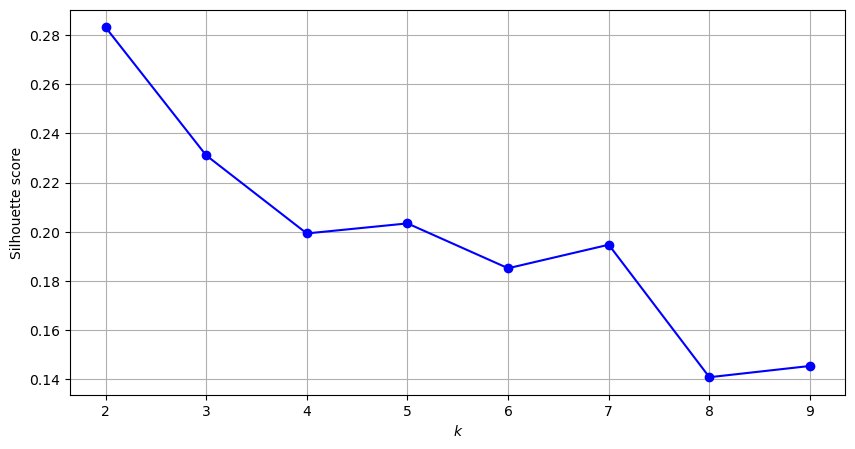

In [17]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(projected_data)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(projected_data, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

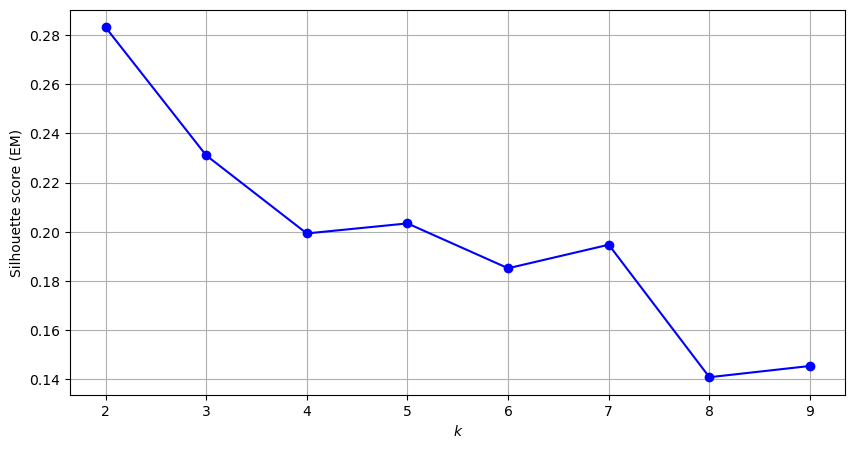

In [18]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(projected_data)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(projected_data, model.predict(projected_data))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#Random forest 
X = customer_segmentation.values[:,:-2]
y = customer_segmentation.values[:,-1]

X_train1_b, X_test1_b, y_train1_b, y_test1_b = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = X_train1_b, X_test1_b, y_train1_b, y_test1_b
y_train1_b.sum(), y_test1_b.sum()

scaler = StandardScaler()
scaler.fit(X_train1_b)
scaler.mean_
X_train1 = scaler.transform(X_train1_b)
print("Train: ", X_train1.shape, "Positive examples: ", y_train1.sum())

X_test1 = scaler.transform(X_test1_b)
print("Test: ", X_test1.shape, "Positive examples: ", y_test1.sum())

df1 = df.copy()
print(df.columns)


model = RandomForestClassifier(n_estimators=100, max_depth=3)
model.fit(X_train1, y_train1)
importance = model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
importance = sorted(importance)
print(importance)
# Feature 7,3,16,9,15,8,5 (Recency,Marital_Status,NumCatalogPurchases,MntFruits,NumWebPurchases,MntWines,Kidhome)
mask_d1 = np.array(importance)>0.05
print(mask_d1)

Train:  (1792, 26) Positive examples:  700.0
Test:  (448, 26) Positive examples:  182.0
Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Cluster', 'PC1',
       'PC2'],
      dtype='object')
Feature: 0, Score: 0.00088
Feature: 1, Score: 0.00004
Feature: 2, Score: 0.00006
Feature: 3, Score: 0.10901
Feature: 4, Score: 0.00584
Feature: 5, Score: 0.00219
Feature: 6, Score: 0.00019
Feature: 7, Score: 0.09776
Feature: 8, Score: 0.07263
Feature: 9, Score: 0.24978
Feature: 10, Score: 0.10181
Feature: 11, Score: 0.05421
Feature: 12, Score: 0.01430
Feature: 13, Score: 0.00321

In [116]:
customer_segmentation=pd.read_csv("customer_segmentation.csv")
DF_RF = customer_segmentation[['Recency', 'Marital_Status', 'NumCatalogPurchases', 'MntFruits', 'NumWebPurchases', 'MntWines', 'Kidhome']]
# Replace categorical variables with numeric values
label_encoder = LabelEncoder()
DF_RF['Marital_Status'] = label_encoder.fit_transform(DF_RF['Marital_Status'])

# Selecting features for clustering
X1 = DF_RF

# Standardize the features
scaler = StandardScaler()
X_scaled1 = scaler.fit_transform(X1)


C:\Users\Edward\AppData\Local\Temp\ipykernel_19492\5136146.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_RF['Marital_Status'] = label_encoder.fit_transform(DF_RF['Marital_Status'])


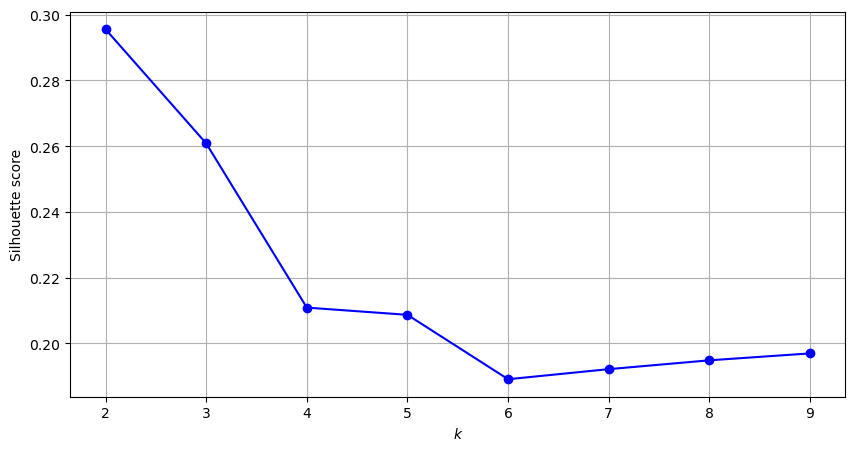

In [117]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled1)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(X_scaled1, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

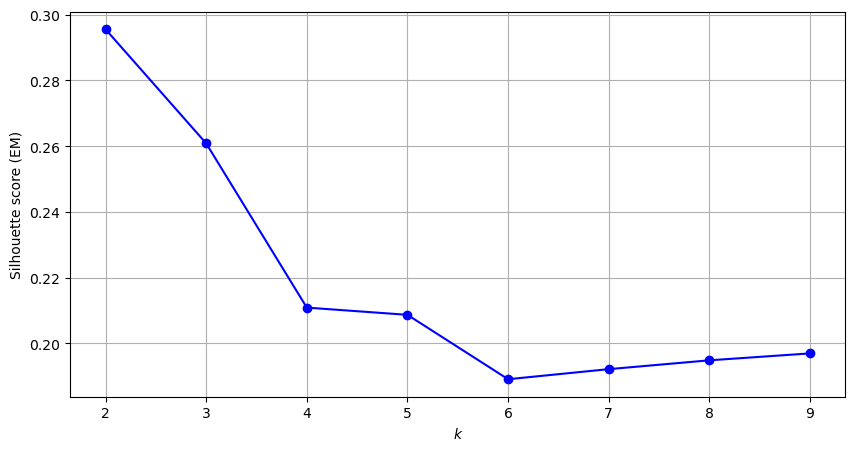

In [118]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(X_scaled1)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(X_scaled1, model.predict(X_scaled1))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()

